In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def loadMrd(fpath):
    try:
        with open(fpath, 'rb') as f:
            mrd = f.read()
    except Exception as e:
        print(e)
        return None

    if len(mrd) < 512:
        return None

    samples=int(0).from_bytes(mrd[0:4], byteorder='little', signed=True)
    views=int(0).from_bytes(mrd[4:8], byteorder='little', signed=True)
    views2=int(0).from_bytes(mrd[8:12], byteorder='little', signed=True)
    slices = int(0).from_bytes(mrd[12:16], byteorder='little', signed=True)
    # 16-18 Unspecified
    datatype=int(0).from_bytes(mrd[18:20], byteorder='little', signed=True)
    # 20-152 Unspecified
    echoes=int(0).from_bytes(mrd[152:156], byteorder='little', signed=True)
    experiments=int(0).from_bytes(mrd[156:160], byteorder='little', signed=True)

    nele = experiments*echoes*slices*views*views2*samples

    if datatype & 0xf == 0:
        dt='u1'
        eleSize = 1
    elif datatype & 0xf == 1:
        dt='i1'
        eleSize = 1
    elif datatype & 0xf == 2:
        dt='i2'
        eleSize = 2
    elif datatype & 0xf == 3:
        dt='i2'
        eleSize = 2
    elif datatype & 0xf == 4:
        dt='i4'
        eleSize = 4
    elif datatype & 0xf == 5:
        dt='f4'
        eleSize = 4
    elif datatype & 0xf == 6:
        dt='f8'
        eleSize = 8
    else:
        print('Unknown data type in the MRD file!')
        return None
    if datatype & 0x10:
        eleSize *= 2

    #
    # XXX - The value of NO_AVERAGES in PPR cannot be used to
    #       calculate the data size.
    #
    posPPR = mrd.rfind(b'\x00')
    if posPPR == -1:
        print('Corrupted MRD file!')
        return None
    posPPR += 1
    dataSize = posPPR - 512 - 120
    if dataSize < nele * eleSize:
        print('Corrupted MRD file!')
        return None

    navg = dataSize // (nele * eleSize)

    if navg > 1:
        data = np.zeros((experiments,echoes,slices,views,views2,samples),
                        dtype=(np.complex128 if dt == 'f8' else np.complex64) if (datatype & 0x10) else (np.float64 if dt == 'f8' else np.float32))

    offset = 512
    for i in range(navg):
        x = np.frombuffer(mrd[offset:],
                          dtype=[('re', '<'+dt), ('im', '<'+dt)] if (datatype & 0x10) else ('<'+dt),
                          count=nele)
        if dt in ('f4', 'f8'):
            pass
        else:
            x = x.astype(np.float32)

        if datatype & 0x10:
            if dt in ('f8',):
                x = x.view(np.complex128)
            else:
                x = x.view(np.complex64)

        x = x.reshape((experiments,echoes,slices,views,views2,samples))

        offset += nele * eleSize

        if navg > 1:
            data += x

    if navg > 1:
        data /= navg
    else:
        data = x

    return data

def reconImages(kdata, size):
    #experiments, echoes, slices, views, views2, samples = kdata.shape
    idata = np.fft.fftshift(np.fft.ifftn(kdata, s=(size, kdata.shape[4], size),
                                         axes=(3,4,5)),
                            axes=(3,4,5))

    idata = np.abs(idata)
    idata /= idata.max()

    images = []
    for e in range(idata.shape[0]):
        for k in range(idata.shape[1]):
            for s in range(idata.shape[2]):
                for v2 in range(idata.shape[4]):
                    images.append(idata[e, k, s, :, v2, :])

    return np.array(images)

def yangleiReconImages_old(kdatas, size):
    kdata_obj = None
    kdata_nos = []
    for kd in kdatas:
        if kd is not None:
            if kdata_obj is None:
                kdata_obj = kd
            else:
                kdata_nos.append(kd)

    if len(kdata_nos) > 0:
        nbin = 8
        npb = kdata_nos[0].shape[5]//nbin

        if (nbin*npb) != kdata_nos[0].shape[5]:
            logging.warning('The number of samples must be multiple of %d. Fallback to the default.' % nbin)
        else:
            idata_obj = np.fft.fft(kdata_obj)
            idata_nos = [np.fft.fft(kdata_nos[i]) for i in range(len(kdata_nos))]

            X = np.concatenate(
                [idata_nos[_][0, 0, 0, 0, 0, :][np.newaxis] for _ in range(len(idata_nos))],
                axis=0)
            y = idata_obj[0, 0, 0, 0, 0, :]

            for i in range(nbin):
                rng = range(i*npb, (i+1)*npb)
                _ = np.linalg.lstsq(X[:, rng].T, y[rng], rcond=None)
                b = _[0][:, np.newaxis]

                for e in range(idata_obj.shape[0]):
                    for k in range(idata_obj.shape[1]):
                        for s in range(idata_obj.shape[2]):
                            for v in range(idata_obj.shape[3]):
                                for v2 in range(idata_obj.shape[4]):
                                    F = np.concatenate(
                                        [idata_nos[_][e, k, s, v, v2, [rng]] for _ in range(len(idata_nos))],
                                        axis=0).T
                                    idata_obj[e, k, s, v, v2, [rng]] -= (F @ b).T

            kdata_obj = np.fft.ifft(idata_obj)

    return reconImages(kdata_obj, size)

def yangleiReconImages(kdatas, size):
    kdata_obj = None
    kdata_nos = []
    for kd in kdatas:
        if kd is not None:
            if kdata_obj is None:
                kdata_obj = kd
            else:
                kdata_nos.append(kd)

    if len(kdata_nos) > 0:
        nbin = 8
        npb = kdata_nos[0].shape[5]//nbin

        if (nbin*npb) != kdata_nos[0].shape[5]:
            logging.warning('The number of samples must be multiple of %d. Fallback to the default.' % nbin)
        else:
            idata_obj = np.fft.fft(kdata_obj)
            idata_nos = np.array([np.fft.fft(kdata_nos[i]) for i in range(len(kdata_nos))])

            X = idata_nos[:, 0, 0, 0, 0, 0, :]
            y = idata_obj[   0, 0, 0, 0, 0, :]
            c = np.zeros((idata_nos.shape[0], nbin), dtype=y.dtype)

            for i in range(c.shape[1]):
                rng = range(i*npb, (i+1)*npb)
                _ = np.linalg.lstsq(X[:, rng].T, y[rng], rcond=None)
                c[:, i] = _[0]

            idata_obj -= np.reshape(np.sum(c[:, None, None, None, None, None, :, None] *
                                           idata_nos.reshape((idata_nos.shape[0], idata_nos.shape[1], idata_nos.shape[2],
                                                              idata_nos.shape[3], idata_nos.shape[4], idata_nos.shape[5],
                                                              c.shape[1], -1)),
                                           axis=0),
                                    idata_obj.shape)

            kdata_obj = np.fft.ifft(idata_obj)

    return reconImages(kdata_obj, size)

def vis_square(data, title=''):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""

    # normalize data for display
    # data = (data - data.min()) / (data.max() - data.min())

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant',
                  constant_values=max(1, data.max()))  # pad with ones (white)

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])

    plt.imshow(data, cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title)

    return n

def vis_square_annotate(data, rois=[], title=''):
    fig, ax = plt.subplots(figsize = (12, 12), dpi = 100)
    n = vis_square(data, title)
    padding = 1  # XXX - vis_square pad one white pixel between images

    for r in rois:
        rect = Rectangle((rois[r][1]*(data.shape[1]+padding)+rois[r][2],
                          rois[r][0]*(data.shape[2]+padding)+rois[r][3]),
                         rois[r][4], rois[r][5], edgecolor='g', fill=False)

        roi = data[rois[r][0] * n + rois[r][1],
                   rois[r][3]:(rois[r][3]+rois[r][5]),
                   rois[r][2]:(rois[r][2]+rois[r][4])]

        # plt.figure()
        # plt.imshow(roi, cmap='gray')
        # plt.axis('off')

        ax.add_patch(rect)
        ax.annotate('%s Mean:%.4f,StdDev:%.4f' % (r, roi.mean(), roi.std()),
                    rect.get_xy(), color='r', weight='normal',
                    fontsize=10, ha='left', va='baseline')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torch.optim as optim

import scipy.fft as sfft # XXX - numpy.fft always returns complex128

class HYCDataset(Dataset):
    def __init__(self, seti, scan_or_noise, expi):
        super().__init__()
        files = [os.path.join(os.path.abspath(os.path.curdir), 'datasets', 'HYC',
                              seti, '%s data' % scan_or_noise, expi,
                              '%s%d.mrd' % (scan_or_noise, _)) for _ in range(1,5)]
        self.data = self.fromMrd([loadMrd(_) for _ in files])

    def fromMrd(self, mrds):
        '''Convert a list MRD data from several coils to a designated shape

        Args:
            mrds (list): a list of numpy array of MRD data with the shape
                (experiments, echoes, slices, views, views2, samples)
            Note that only experiments=1 and echoes=1 are used.
        Returns:
            numpy.ndarray: a numpy array of the shape
                (slices_or_views2, views, samples, 2, coils)
            The `2` in the dimension exists because we assume a complex data
            type.
        '''
        mrds = [_ for _ in mrds if _ is not None]
        print('(slices=%d, views=%d, views2=%d, samples=%d)' %
              (mrds[0].shape[2], mrds[0].shape[3], mrds[0].shape[4], mrds[0].shape[5]))

        if mrds[0].shape[2] > 1:
            assert mrds[0].shape[4] == 1
            self._3d = False
        else:
            self._3d = True

        mrds = [sfft.fft(_) for _ in mrds]

        data = np.array(mrds)
        data = np.stack([data.real, data.imag], axis=-1)

        data = data[:, 0, 0, ...]

        data = data.transpose((1, 3, 2, 4, 5, 0))
        if self._3d:
            data = data[0, ...]
        else:
            data = data[:, 0, ...]

        # print('fromMrd out:', data.shape)
        return data

    def toMrd(self, data):
        '''Convert a numpy array to a list of MRD data

        Args:
            data (numpy.ndarray): data has the shape of
                (slices_or_views2, views, samples, 2, coils)
        Returns:
            list: a list of MRD data with the shape
                (1, 1, slices, views, views2, samples)
        '''
        # print('   toMrd in:', data.shape)
        mrds = []
        for i in range(data.shape[4]):
            x = data[:, :, :, :, i]
            # print(x.shape)
            if self._3d:
                x = np.expand_dims(x, (0, 1, 2))
            else:
                x = np.expand_dims(x, (0, 1, 3))
            # print(x.shape)
            x = x.transpose((0, 1, 2, 4, 3, 5, 6))
            # print(x.shape)
            x = np.vectorize(complex)(x[..., 0], x[..., 1])
            # print(x.shape)
            mrds.append(sfft.ifft(x))
        return mrds

rois = {
#        (row, col, x-off, y-off, width, height)
    '1n' : (2,   1,    5,    5,     499,   79),
    '1s' : (2,   1,   380,  315,    50,   50),
    # '2n' : (2,   0,    5,    5,     499,   79),
    # '2s' : (2,   0,   156,  170,    290,   180),
    '3n' : (2,   3,    5,    5,     499,   79),
    '3s' : (2,   3,   370,  305,    50,   50),
}

In [35]:
methodName = 'CNN1.Full'

class DatasetForFull(HYCDataset):
    def __init__(self, seti, scan_or_noise, expi):
        super().__init__(seti, scan_or_noise, expi)
    def __len__(self):
        '''self.data.shape = (slices_or_views2, views, samples, 2, coils)
        '''
        return self.data.shape[0]
    def __getitem__(self, index):
        return (self.data[index, ..., :1],
                self.data[index, ..., 1:])

class NetFull(nn.Module):
    def __init__(self, channels, kernel_size):
        super().__init__()

        self.conv1 = nn.Conv2d(channels, channels, (2, kernel_size),
                               padding=(1, 0), stride=(2, 1), groups=channels, bias=None)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv1(torch.index_select(x, 2, torch.LongTensor([1,0])))

        y = torch.concat((x1[..., [0], :] - x1[..., [1], :],
                          x2[..., [0], :] + x2[..., [1], :]),
                         2)
        return y

    def wrap(self, x):
        '''Convert a tensor of external shape to an internal shape
        required by the network

        Args:
            x (Tensor): a tensor of the shape
               (batch, views, samples, 2, coils)
        Returns:
            Tensor: a tensor of the shape
               (batch, views*samples, 2, coils)
        '''
        # print(' wrap in:', x.shape)
        self.views = x.shape[1]
        x = x.reshape((x.shape[0], -1, x.shape[3], x.shape[4]))
        # print('wrap out:', x.shape)
        return x

    def unwrap(self, x):
        '''Convert a tensor from internal shape to external shape

        Args:
            x (Tensor): a tensor of the shape
               (slices_or_views2, views*samples, 2, coils)
        Returns:
            Tensor: a tensor of the shape
               (slices_or_views2, views, samples, 2, coils)
        '''
        # print(' unwrap in:', x.shape)
        x = x.reshape((x.shape[0], self.views, -1, x.shape[2], x.shape[3]))
        # print('unwrap out:', x.shape)
        return x

# Load the data set
trainSet = DatasetForFull('set 4', 'noise', 'exp2')
testSet = DatasetForFull('set 4', 'scan', 'exp1')

# Setup the model
views, samples, _, coils = trainSet[0][1].shape
model = NetFull(views*samples, coils)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print('Input Shape:', (1, views*samples, 2, coils))
print(summary(model,  (1, views*samples, 2, coils)))

# Hyper-parameters
num_epochs = 200
batch_size = 12#len(trainSet)
learning_rate = 0.1

(slices=1, views=128, views2=24, samples=128)
(slices=1, views=128, views2=24, samples=128)
Input Shape: (1, 16384, 2, 3)


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Conv2d: 1]

In [ ]:
methodName = 'CNN1.Small.prescan'

class DatasetForSmall(HYCDataset):
    def __init__(self, train_or_test, seti, scan_or_noise, expi):
        super().__init__(seti, scan_or_noise, expi)
        self.train_or_test = train_or_test
    def __len__(self):
        '''self.data.shape = (slices_or_views2, views, samples, 2, coils)
        '''
        return self.data.shape[0]*self.data.shape[1]
    def __getitem__(self, index):
        views = index % self.data.shape[1]
        views2 = index // self.data.shape[1]
        if self.train_or_test == 'train':
            return (self.data[views2, 0, ..., :1],
                    self.data[views2, 0, ..., 1:]) # (target, inputs)
        else:
            return (self.data[views2, views, ..., :1],
                    self.data[views2, views, ..., 1:]) # (target, inputs)
    def toMrd(self, x):
        x = x.reshape((-1, self.data.shape[1],
                       x.shape[1], x.shape[2], x.shape[3]))
        return super().toMrd(x)

class NetSmall(nn.Module):
    def __init__(self, bins, coils):
        super().__init__()
        self.bins = bins
        self.conv1 = nn.Conv3d(bins, bins, (1, 2, coils), groups=bins,
                               padding=(0, 1, 0), stride=(1, 2, 1), bias=None)
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv1(torch.index_select(x, 3, torch.LongTensor([1,0])))

        y = torch.concat((x1[..., [0], :] - x1[..., [1], :],
                          x2[..., [0], :] + x2[..., [1], :]),
                         3)
        return y
    def wrap(self, x):
        '''Convert a tensor of external shape to an internal shape
        required by the network

        Args:
            x (Tensor): a tensor of the shape
               (batch, samples, 2, coils)
        Returns:
            Tensor: a tensor of the shape
               (batch, bins, samples/bins, 2, coils)
        '''
        # print(' wrap in:', x.shape)
        x = x.reshape((x.shape[0], self.bins, x.shape[1]//self.bins, x.shape[2], x.shape[3]))
        # print('wrap out:', x.shape)
        return x

    def unwrap(self, x):
        '''Convert a tensor from internal shape to external shape

        Args:
            x (Tensor): a tensor of the shape
               (batch, bins, samples/bins, 2, coils)
        Returns:
            Tensor: a tensor of the shape
               (batch, samples, 2, coils)
        '''
        # print(' unwrap in:', x.shape)
        x = x.reshape((x.shape[0], x.shape[1]*x.shape[2], x.shape[3], x.shape[4]))
        # print('unwrap out:', x.shape)
        return x

# Load the data set
trainSet = DatasetForSmall('test', 'set 4', 'noise', 'exp1')
testSet = DatasetForSmall('test', 'set 4', 'noise', 'exp1')

# Setup the model
bins = 8
samples, _, coils = trainSet[0][1].shape
assert samples % bins == 0, '`samples` must be divisible by `bins`'

model = NetSmall(bins, coils)
print('Input Shape:', (1, bins, samples//bins, 2, coils))
print(summary(model,  (1, bins, samples//bins, 2, coils)))

# Hyper-parameters
num_epochs = 200
batch_size = 24
learning_rate = 0.0001

In [34]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=1)

loss_train = []
lr_train = []

# Kick it off
startTime = time.time()
for epoch in range(num_epochs):
    loss_batch = []
    for idx, (targets, inputs) in enumerate(DataLoader(trainSet,
                                                       batch_size=batch_size,
                                                       shuffle=True)):
        targets = model.wrap(targets)
        inputs = model.wrap(inputs)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_batch.append(loss.item())

    if (epoch+1) % 20 == 0:
        print ('Epoch [{}/{}], LR: {:e}, Loss: {:.4f}'.format(epoch+1,
                                                              num_epochs,
                                                              optimizer.param_groups[0]['lr'],
                                                              sum(loss_batch)/len(loss_batch)))
    lr_train.append(optimizer.param_groups[0]['lr'])
    loss_train.append(sum(loss_batch)/len(loss_batch))

    scheduler.step()
endTime = time.time()

print('Time elapsed: %.2fs.' % (endTime-startTime))

fig, ax1 = plt.subplots(
    figsize=(12, 4), #inches
)
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(len(loss_train)), loss_train, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Learning rate', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(len(lr_train)), lr_train, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

RuntimeError: Expected a 'cuda' device type for generator but found 'cpu'

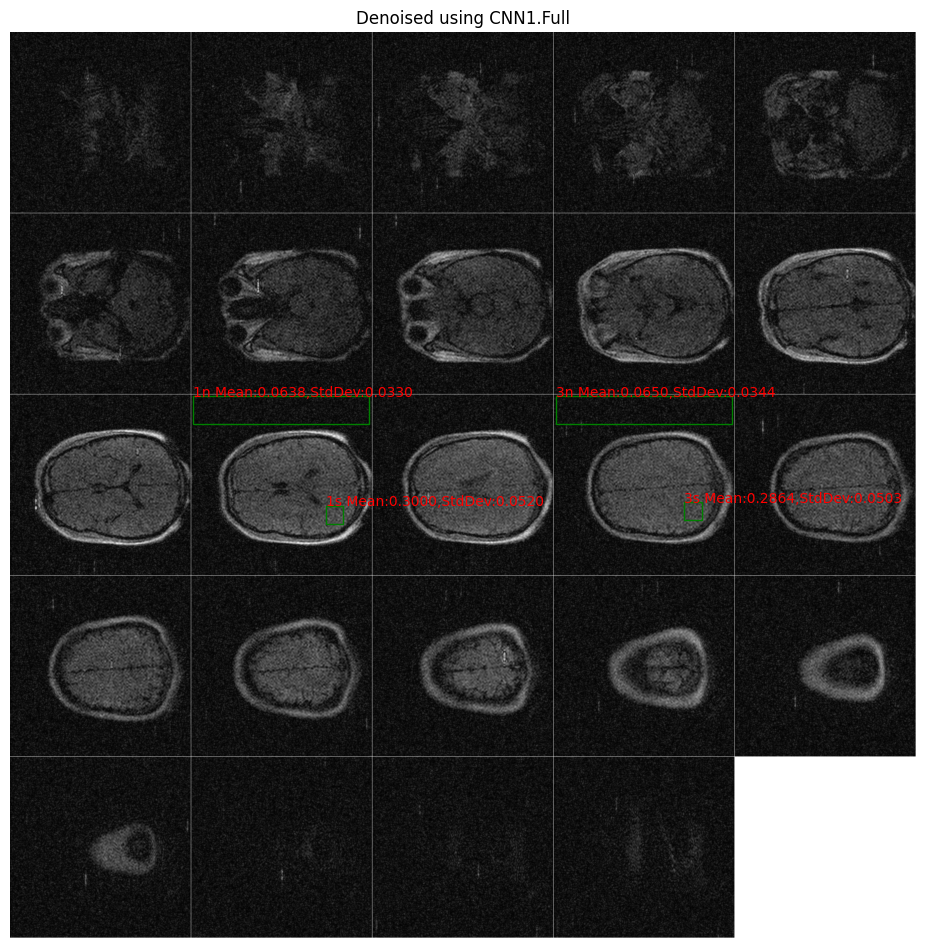

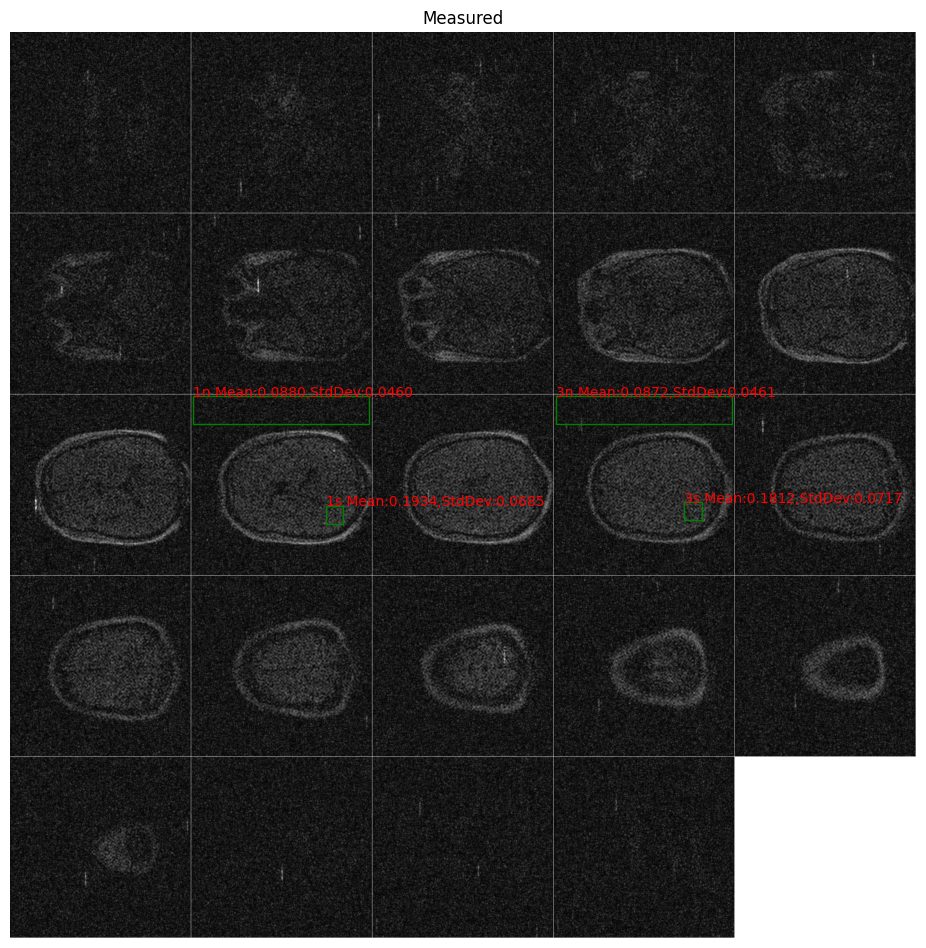

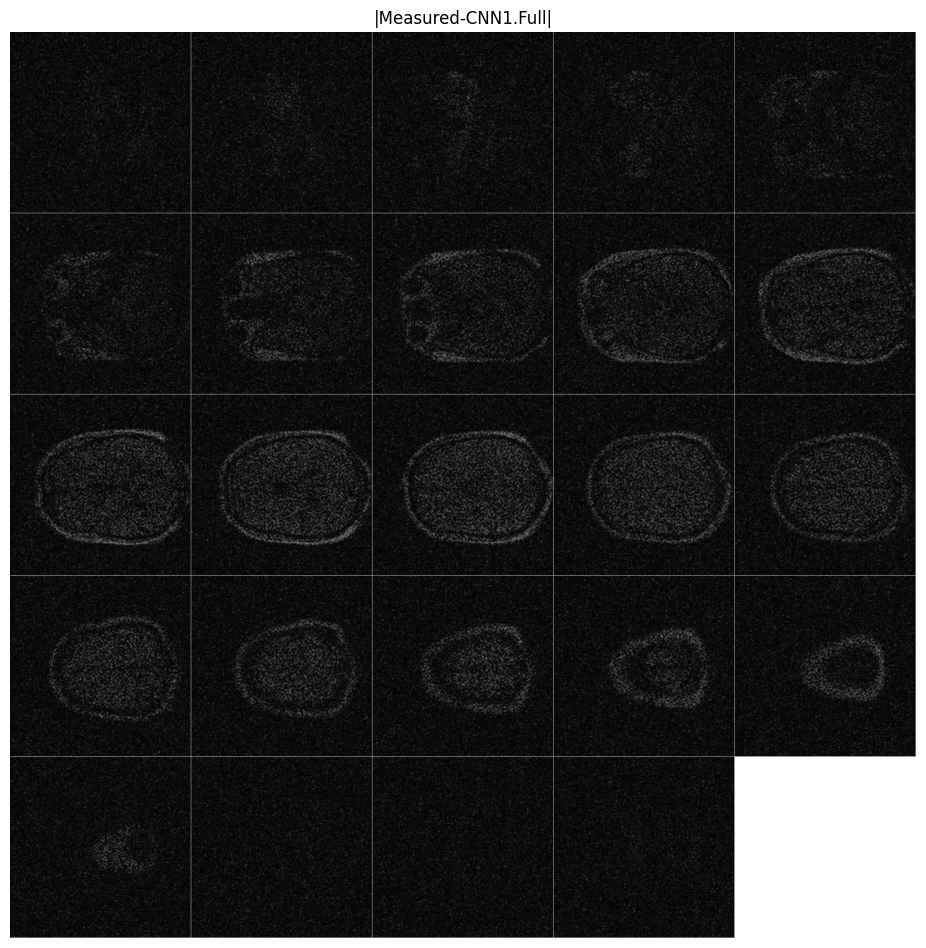

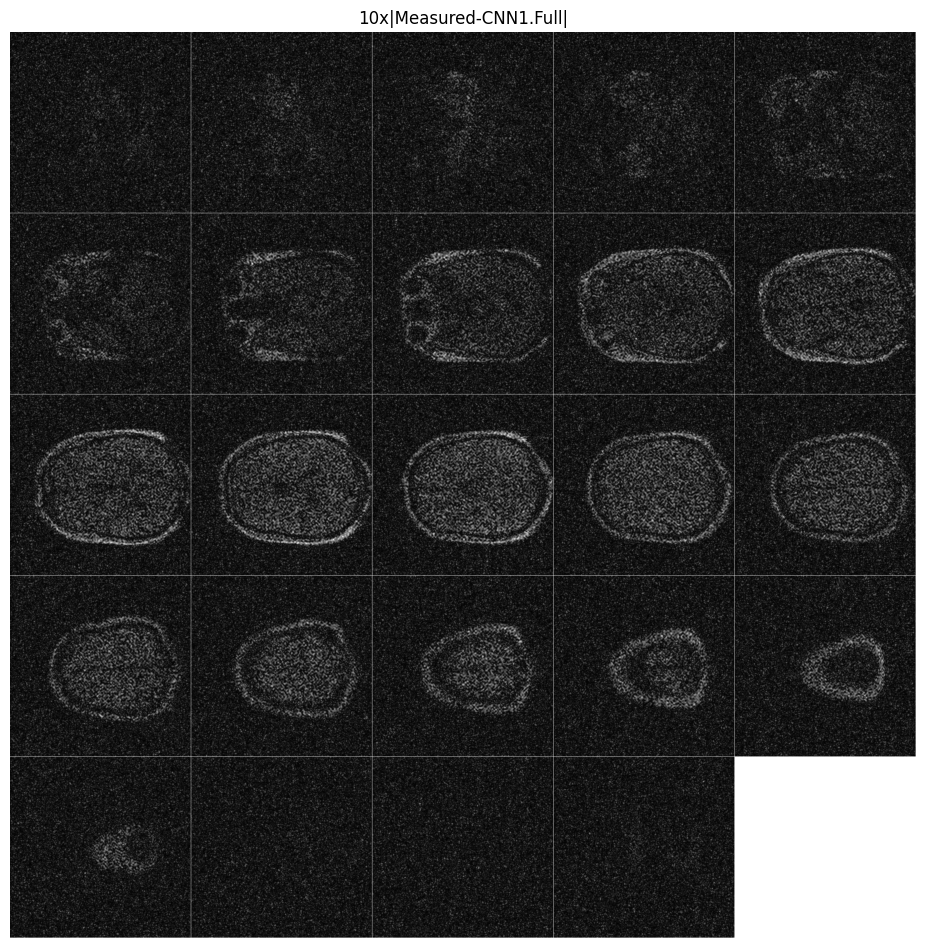

In [60]:
# Evaluate the test set
model.eval()
with torch.no_grad():

    # print(model.conv1.weight.shape)
    # w = model.conv1.weight.clone().detach().numpy()
    # w -= w.min()
    # w = w.reshape(128, 128, 3)
    # plt.figure(figsize=(12, 8))
    # for i in range(w.shape[2]):
    #     plt.subplot(1, w.shape[2], i+1)
    #     plt.title(f'Coil #{i+1}')
    #     plt.axis('off')
    #     plt.imshow(w[..., i], cmap='gray')
    # plt.show()

    for idx, (measures, inputs) in enumerate(DataLoader(testSet,
                                                        batch_size=len(testSet))):
        measures = model.wrap(measures)
        inputs = model.wrap(inputs)

        # Forward
        noises = model(inputs)

        # Denoise
        recovers = measures - noises

        recovers = model.unwrap(recovers)
        recovers = testSet.toMrd(recovers.numpy())
        recovers = reconImages(recovers[0], 512)

        measures = model.unwrap(measures)
        measures = testSet.toMrd(measures.numpy())
        measures = reconImages(measures[0], 512)

        vis_square_annotate(recovers, rois=rois, title='Denoised using %s' % methodName)
        vis_square_annotate(measures, rois=rois, title='Measured')
        vis_square_annotate(np.abs(recovers - measures), [], title='|Measured-%s|' % methodName)
        vis_square_annotate(10*np.abs(recovers - measures), [], title='10x|Measured-%s|' % methodName)

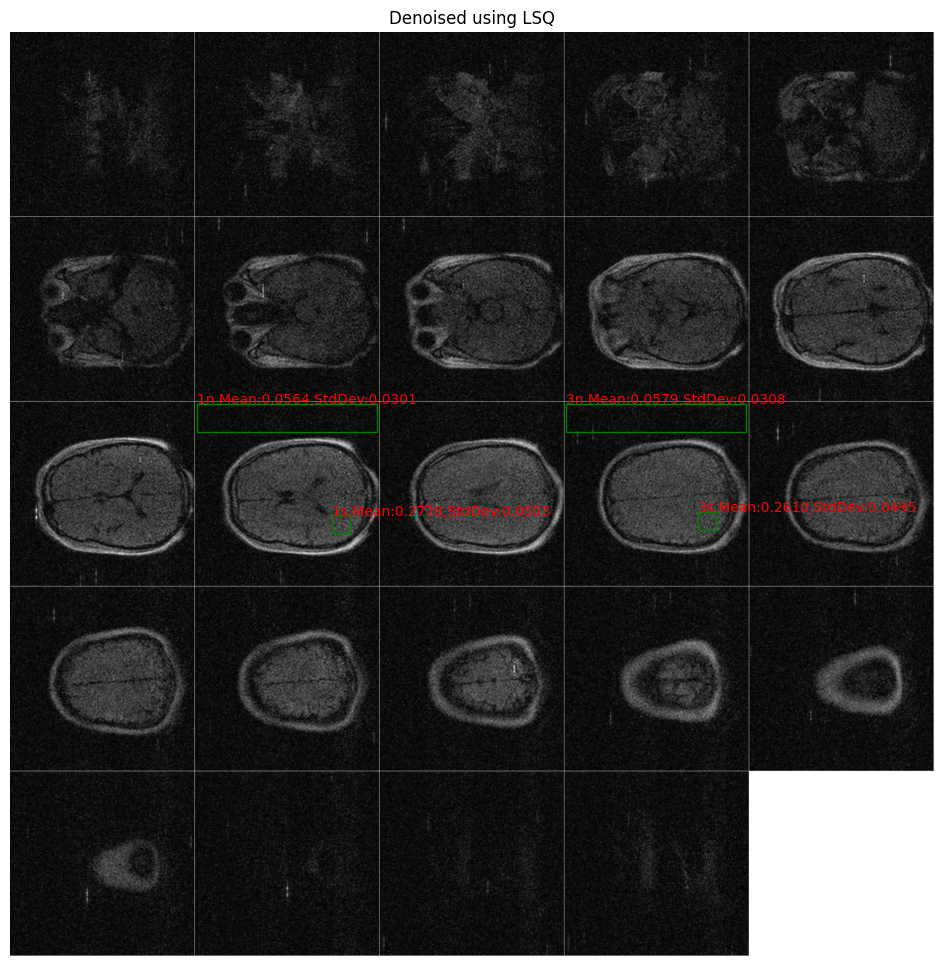

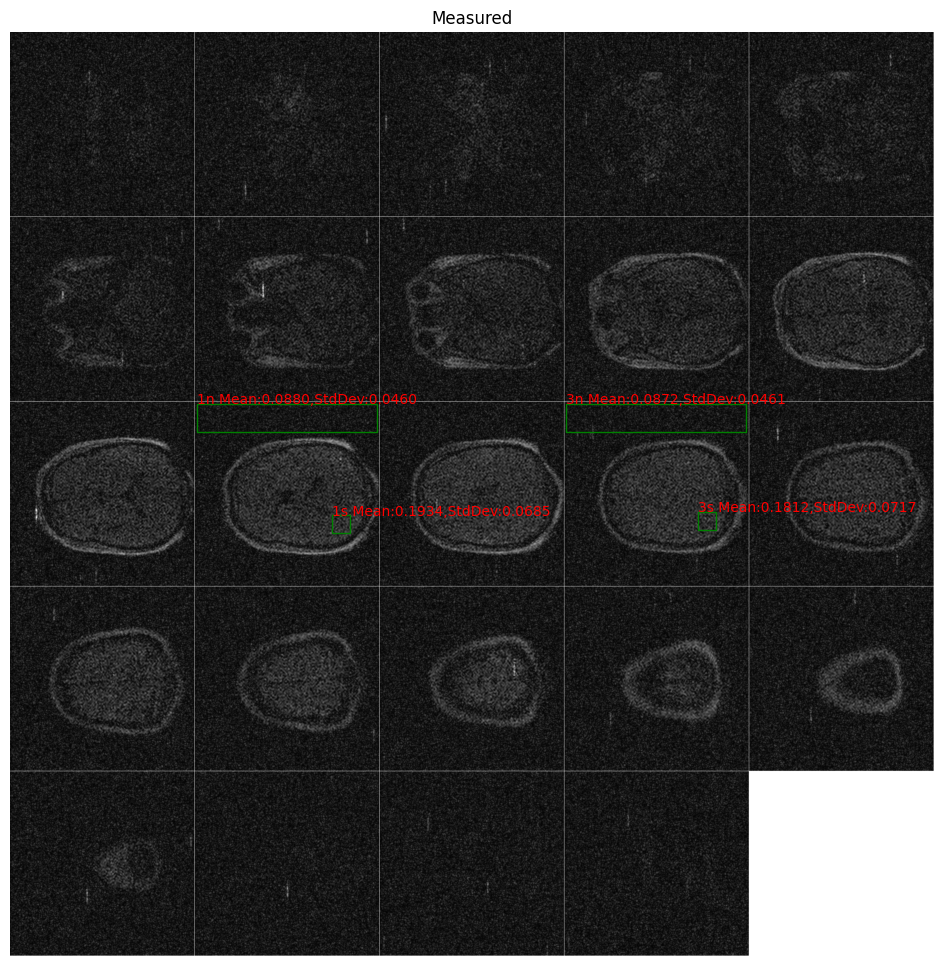

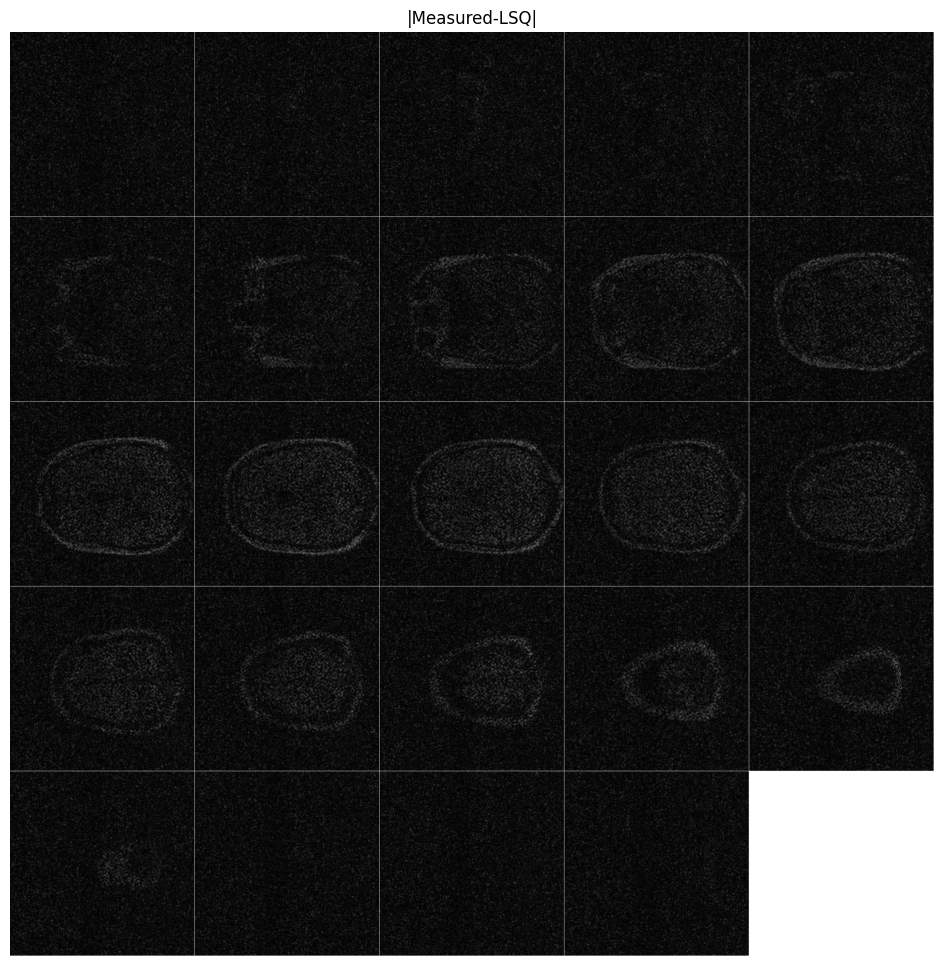

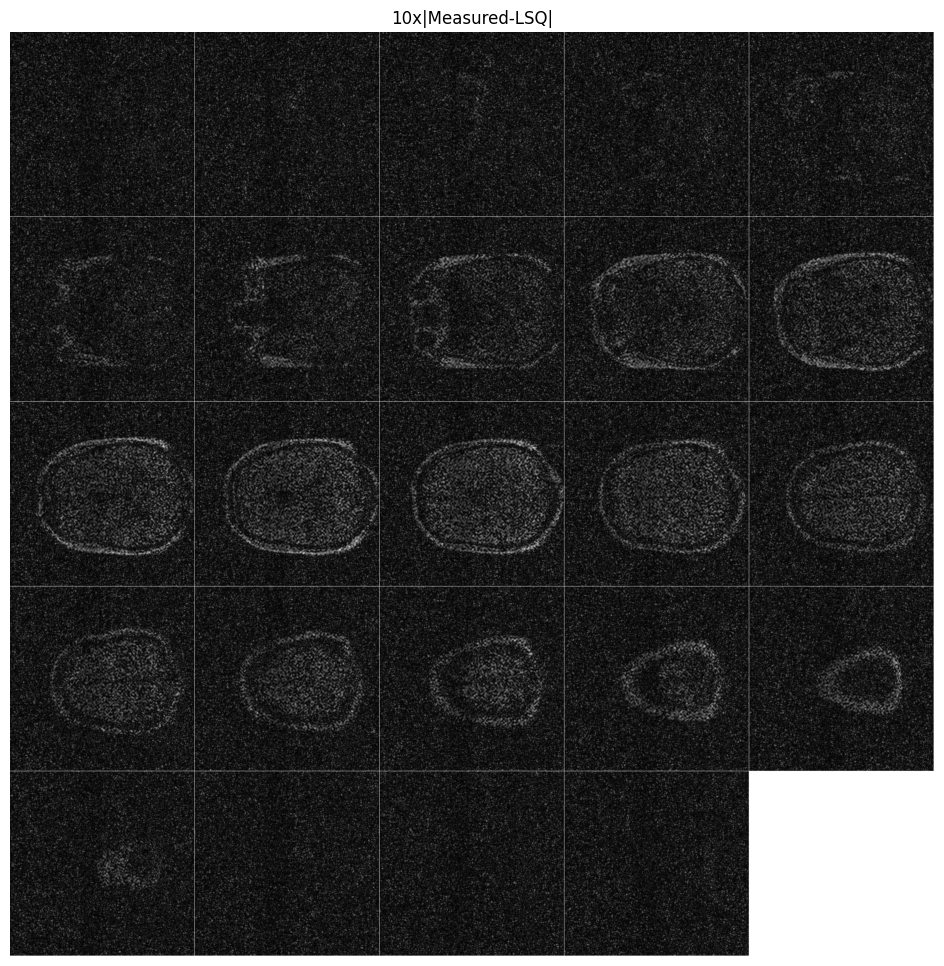

In [5]:
methodName = 'LSQ'

seti = '4'
scan_or_noise = 'scan'
expi = '1'
files = [os.path.join(os.path.abspath(os.path.curdir), 'datasets', 'HYC',
                      'set %s' % seti, '%s data' % scan_or_noise, 'exp%s'%expi,
                      '%s%d.mrd' % (scan_or_noise, _)) for _ in range(1, 5)]
recovers = yangleiReconImages([loadMrd(_) for _ in files], 512)
vis_square_annotate(recovers, rois=rois, title='Denoised using %s' % methodName)
measures = reconImages(loadMrd(files[0]), 512)
vis_square_annotate(measures, rois=rois, title='Measured')
vis_square_annotate(np.abs(recovers - measures), title='|Measured-%s|' % methodName)
vis_square_annotate(10*np.abs(recovers - measures), title='10x|Measured-%s|' % methodName)